In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_dir = "/content/gdrive/MyDrive/Batik Dataset Enhanched/Batik"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=270,
                                   zoom_range=0.2,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='wrap',
                                   validation_split=0.25)


In [6]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 761 images belonging to 20 classes.
Found 240 images belonging to 20 classes.


In [21]:
from tensorflow.keras import layers
from tensorflow.keras import Model

base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', pooling="max",
    classifier_activation=None
)

"""for layer in base_model.layers[:-1]:
    model.add(layer)  """  

# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (20, activation='softmax')(x)           

model = Model(base_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1128 (Conv2D)            (None, None, None, 3 864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1128 (Batch (None, None, None, 3 96          conv2d_1128[0][0]                
__________________________________________________________________________________________________
activation_1128 (Activation)    (None, None, None, 3 0           batch_normalization_1128[0][0]   
____________________________________________________________________________________________

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["acc"])

In [25]:
"""from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_acc')"""

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [26]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=500, steps_per_epoch=15, callbacks=[callbacks])

Epoch 1/500
15/15 [==============================] - 318s 22s/step - loss: 8.1367 - acc: 0.0750 - val_loss: 3.9938 - val_acc: 0.1667
Epoch 2/500
15/15 [==============================] - 68s 5s/step - loss: 3.5037 - acc: 0.1854 - val_loss: 2.6697 - val_acc: 0.2292
Epoch 3/500
15/15 [==============================] - 33s 2s/step - loss: 2.5650 - acc: 0.2474 - val_loss: 2.3993 - val_acc: 0.2958
Epoch 4/500
15/15 [==============================] - 22s 2s/step - loss: 2.3390 - acc: 0.2960 - val_loss: 2.3553 - val_acc: 0.3125
Epoch 5/500
15/15 [==============================] - 17s 1s/step - loss: 2.3186 - acc: 0.2918 - val_loss: 2.3504 - val_acc: 0.3292
Epoch 6/500
15/15 [==============================] - 17s 1s/step - loss: 2.2344 - acc: 0.3340 - val_loss: 2.2481 - val_acc: 0.3583
Epoch 7/500
15/15 [==============================] - 16s 1s/step - loss: 2.0920 - acc: 0.3636 - val_loss: 2.2161 - val_acc: 0.3250
Epoch 8/500
15/15 [==============================] - 16s 1s/step - loss: 2.0801 -

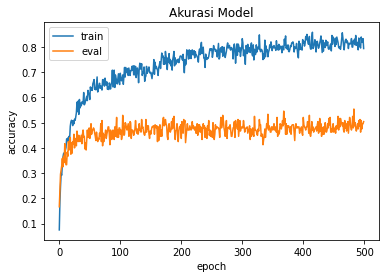

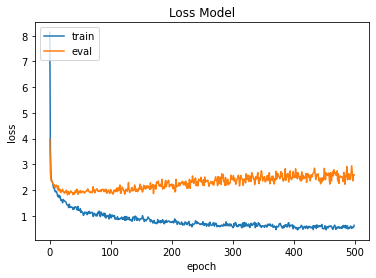

In [27]:
import matplotlib.pyplot as plt

# Accuracy plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [28]:
tf.saved_model.save(model, "BatikClassificationV4-InceptionV3")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: BatikClassificationV4-InceptionV3/assets


In [29]:
!zip -r /content/BatikClassificationV4-InceptionV3.zip /content/BatikClassificationV4-InceptionV3

  adding: content/BatikClassificationV4-InceptionV3/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/assets/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/saved_model.pb (deflated 93%)
  adding: content/BatikClassificationV4-InceptionV3/variables/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.index (deflated 79%)


In [30]:
label = []
import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        label.append(os.path.join(dirname, filename).split('/')[-2])

labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0,
 'batik-betawi': 1,
 'batik-celup': 2,
 'batik-cendrawasih': 3,
 'batik-ceplok': 4,
 'batik-ciamis': 5,
 'batik-garutan': 6,
 'batik-gentongan': 7,
 'batik-kawung': 8,
 'batik-keraton': 9,
 'batik-lasem': 10,
 'batik-megamendung': 11,
 'batik-parang': 12,
 'batik-pekalongan': 13,
 'batik-priangan': 14,
 'batik-sekar-jagad': 15,
 'batik-sidoluhur': 16,
 'batik-sidomukti': 17,
 'batik-sogan': 18,
 'batik-tambal': 19}

In [31]:
y_true = validation_generator.classes

print(y_true)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19]


In [32]:
predictions = model.predict(validation_generator)
y_pred = np.rint(predictions)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[ 0  0 12 10  1 15  0 14  0  0  0  0 17  1  0  1  1  1  1  1  0  0  1  1
  0  2  2  2  2  2  2  2  2  2  2  2  9  3  3  0  3  3  0 10  3 14  2 10
  4  9  0 16 16  0  4  4  4  4  4  4 13  9  0  7 13  0  0  0  0  0  2 16
  0  6  6  6  6  0  0  6  0 19  6  6 13  7  0 10  7 17 10  0  1  0  4  7
  8  8  8 17  8  8  8 12  8  8  8  8 10  0 18 12  0  0 19  0  4  9 18  0
 10 10 10 10 10 10 10 10 10  6 10  0 11 11 11 11 11 11 11 11 11 11 11 11
 12  9 12 12 12 12 12  0 12 12 12 12  0  0  7 13 13  0  5 10  0  0  0 10
 14 10 14 14 15 10 12  0 14 14  0  0  1  6 15 16 15 15 15 15 15 15  0 15
 16 15 16 16 16 16 16  6 16  0 17 16 18 16  9  0  6  5  0 16  0  7 17 16
 12 17  8 15 18  9 12  9 14 18  3 18  0 12  0  0 19 19 19  0  4  0 14  0]


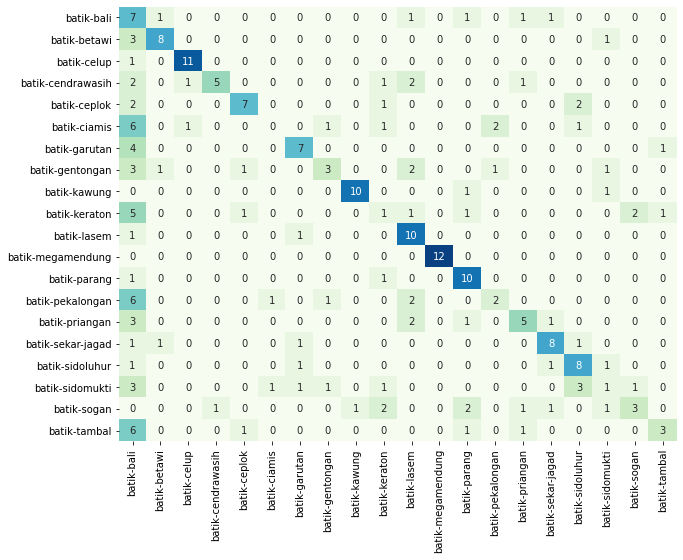

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.58      0.21        12
           1       0.73      0.67      0.70        12
           2       0.85      0.92      0.88        12
           3       0.83      0.42      0.56        12
           4       0.70      0.58      0.64        12
           5       0.00      0.00      0.00        12
           6       0.64      0.58      0.61        12
           7       0.50      0.25      0.33        12
           8       0.91      0.83      0.87        12
           9       0.12      0.08      0.10        12
          10       0.50      0.83      0.62        12
          11       1.00      1.00      1.00        12
          12       0.59      0.83      0.69        12
          13       0.40      0.17      0.24        12
          14       0.56      0.42      0.48        12
          15       0.67      0.67      0.67        12
          16       0.53      0.67      0.59        12
          17       0.17    